In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sb
from analyze_experiment_in_progress import get_data_from_logs
sb.set()

In [9]:
#bert4rec outperforms everything
#experiment_logs = './results/bert4rec_config_2021_11_04T17_15_31/stdout'

#SALREC-BCE-Great
#experiment_logs = './results/bert4rec_config_2021_11_07T22_26_10/stdout'


#SALREC-Lambdarank 0.157107
#experiment_logs = './results/ml_benchmark20m_2021_11_18T16_38_37/stdout'



#Transformer-Lambdarank 0.1603
#experiment_logs = './results/ml_benchmark20m_2021_11_19T17_43_30/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_23T14_39_04/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_25T09_41_35/stdout'

#Fast Lambdarank on dekstop
#experiment_logs = './results/ml_benchmark20m_2021_11_27T23_55_22/stdout'


#Fast Lambdarank on dekstop - 40k, bce slightly better
#experiment_logs = './results/ml_benchmark20m_2021_11_28T08_36_11/stdout'


# Learning rate effects:

# Lambdarank
#experiment_logs = "./results/ml_benchmark20m_2021_11_26T10_36_55/stdout"
#BCE
#experiment_logs = "./results/ml_benchmark20m_2021_11_27T11_36_03/stdout"



#Truncation effects: 
#1-20
#experiment_logs = "./results/ml_benchmark20m_2021_11_28T18_14_50/stdout"

#30-120
#experiment_logs = "./results/ml_benchmark20m_2021_11_29T15_12_00/stdout"


#stream -first run: 
#experiment_logs = "./results/steam_benchmark_2021_12_02T16_41_29/stdout"

#steam - num targets
#experiment_logs = "./results/steam_benchmark_2021_12_04T12_47_09/stdout"


#lambda norm effect:
#experiment_logs = "results/ml_benchmark20m_2021_12_02T10_46_35/stdout"

#truncated lambdarank with bce
#experiment_logs = "./results/ml_benchmark20m_2021_12_05T21_30_29/stdout"


#lambdarank-truncated fixed

#experiment_logs = "./results/ml_benchmark20m_2021_12_07T20_37_41/stdout"



#lambdarank-truncated-bce-focus
experiment_logs = "./results/ml_benchmark20m_2021_12_08T07_39_20/stdout"

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [11]:
data = get_data_from_logs(experiment_logs, 0)

In [12]:
df = pd.DataFrame(data).set_index('model_name')

df.sort_values(df.columns[0])

,ndcg@10,ndcg@2,ndcg@5,ndcg@20,ndcg@40,precision@10,recall@10,SPS@1,SPS@10,MRR,MAP@10,model_build_time,model_inference_time,model_metadata,num_epochs,metrics_history
model_name,,,,,,,,,,,,,,,,
Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:100-lambda_norm:True-truncate:2500-bce_weight:0.75-log_lambdas:True,0.095571,0.051769,0.074676,0.115112,0.135246,0.017725,0.177246,0.037598,0.177246,0.083731,0.070974,3801.002340,169.473300,"{'epochs_trained': 53, 'best_val_ndcg': 0.10513186454772949, 'val_ndcg_history': [[59.74067664146423, 0.029658794403076172], [128.18106412887573, 0.034193992614746094], [196.17804312705994, 0.042540114372968674], [263.9542257785797, 0.04081848263740539...",56,"[{'loss': 5.481, 'ndcg_at_40': 0.0712, 'lambdarank_lambdas_len': 142.3503, 'bce_lambdas_len': 2.1623, 'val_loss': 5.6163, 'val_ndcg_at_40': 0.0297, 'val_lambdarank_lambdas_len': 81.947, 'val_bce_lambdas_len': 2.5782, 'epoch': 1, 'val_ndcg': 0.029658794..."
Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:100-lambda_norm:True-truncate:2500-bce_weight:0.5-log_lambdas:True,0.097041,0.055533,0.079522,0.118018,0.138414,0.017407,0.174072,0.040283,0.174072,0.086830,0.073717,3512.412620,146.797837,"{'epochs_trained': 42, 'best_val_ndcg': 0.10843905806541443, 'val_ndcg_history': [[58.160370111465454, 0.029414497315883636], [120.45821952819824, 0.04026808217167854], [182.68530678749084, 0.036886945366859436], [245.11689257621765, 0.0438002124428749...",56,"[{'loss': 5.7549, 'ndcg_at_40': 0.076, 'lambdarank_lambdas_len': 297.5849, 'bce_lambdas_len': 2.325, 'val_loss': 6.3537, 'val_ndcg_at_40': 0.0294, 'val_lambdarank_lambdas_len': 145.7663, 'val_bce_lambdas_len': 1.8989, 'epoch': 1, 'val_ndcg': 0.02941449..."
Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:100-lambda_norm:True-truncate:2500-bce_weight:0.99-log_lambdas:True,0.099024,0.054890,0.079542,0.120342,0.138998,0.017944,0.179443,0.039795,0.179443,0.087680,0.074625,3542.308933,145.896074,"{'epochs_trained': 46, 'best_val_ndcg': 0.11025770008563995, 'val_ndcg_history': [[56.54860544204712, 0.02513878606259823], [120.38779997825623, 0.03575632721185684], [183.39167761802673, 0.0380190871655941], [246.69032502174377, 0.04834168404340744], ...",56,"[{'loss': 8.888, 'ndcg_at_40': 0.0701, 'lambdarank_lambdas_len': 5.8762, 'bce_lambdas_len': 0.6989, 'val_loss': 9.2413, 'val_ndcg_at_40': 0.0251, 'val_lambdarank_lambdas_len': 3.693, 'val_bce_lambdas_len': 0.1271, 'epoch': 1, 'val_ndcg': 0.025138786062..."
Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:100-lambda_norm:True-truncate:2500-bce_weight:0.9-log_lambdas:True,0.103187,0.055364,0.082042,0.123365,0.145692,0.019165,0.191650,0.038574,0.191650,0.089550,0.076457,3594.755165,167.361168,"{'epochs_trained': 56, 'best_val_ndcg': 0.10485143959522247, 'val_ndcg_history': [[56.9344048500061, 0.02747509628534317], [120.92950487136841, 0.03161682188510895], [184.74910306930542, 0.04135161638259888], [248.7184545993805, 0.044894006103277206], ...",56,"[{'loss': 7.2617, 'ndcg_at_40': 0.0651, 'lambdarank_lambdas_len': 66.0945, 'bce_lambdas_len': 1.9148, 'val_loss': 8.4973, 'val_ndcg_at_40': 0.0275, 'val_lambdarank_lambdas_len': 38.1765, 'val_bce_lambdas_len': 1.5697, 'epoch': 1, 'val_ndcg': 0.02747509..."
Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:100-lambda_norm:True-truncate:2500-bce_weight:0.95-log_lambdas:True,0.105195,0.060131,0.086167,0.127623,0.149083,0.018848,0.188477,0.042725,0.188477,0.093494,0.079876,3522.838176,145.512520,"{'epochs_trained': 56, 'best_val_ndcg': 0.10885428637266159, 'val_ndcg_history': [[56.213844299316406, 0.028300616890192032], [120.03297686576843, 0.03334563598036766], [183.48384523391724, 0.035618267953395844], [246.3080506324768, 0.03721660003066063...",56,"[{'loss': 9.5493, 'ndcg_at_40': 0.0664, 'lambdarank_lambdas_len': 32.4275, 'bce_lambdas_len': 1.4255, 'val_loss': 10.9602, 'val_ndcg_at_40': 0.0283, 'val_lambdarank_lambdas_len': 22.261, 'val_bce_lambdas_len': 0.8124

<Figure size 1152x648 with 0 Axes>

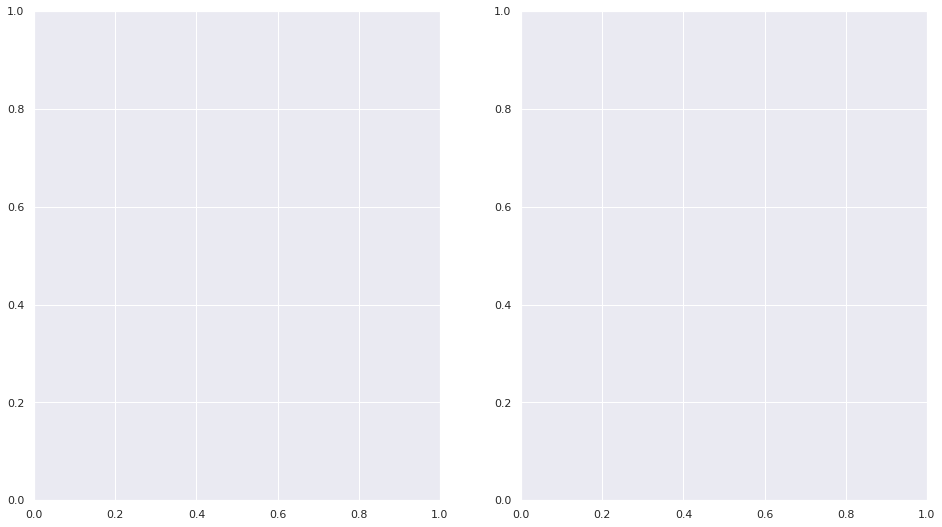

In [13]:
moving_average_steps=1
max_points = 30000


def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))

axises = ['epoch', 'total_training_time']

fig, ax = plt.subplots(1, len(axises))
fig.set_figheight(9)
fig.set_figwidth(16)

interesting_models = ['Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:100-lambda_norm:True-truncate:1000-bce_weight:0.1-log_lambdas:True']
second_metrics = {}

for recommender in data:
    if recommender['model_name'] not in interesting_models:
        continue
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        metric_name = 'val_ndcg'
        second_metric_name = 'ndcg_at_40'
        metric = moving_average(get_metric(history, metric_name), moving_average_steps)[:max_points]
        if second_metric_name != None:
            second_metric = moving_average(get_metric(history, second_metric_name), moving_average_steps)[:max_points]
        #success = get_metric(history, 'Success_at_4')
        #val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        for axis_num in range(len(axises)):
            axis_name = axises[axis_num]
            axis = get_metric(history, axis_name)[moving_average_steps - 1:][:max_points]
            ax[axis_num].plot(axis, metric,label=recommender['model_name'])
            
            ax[axis_num].set_xlabel(axis_name)
            if axis_num == 0:
                ax[axis_num].set_ylabel(metric_name)
            
            if (second_metric_name != None):
                if axis_num not in second_metrics:
                    second_metrics[axis_num] = ax[axis_num].twinx()
                    print(axis_num, second_metrics.keys())
                ax2 = second_metrics[axis_num]
                if axis_num == 1:
                    ax2.set_ylabel(second_metric_name)
                ax2.plot(axis, second_metric, '--', label=recommender['model_name'],)

            
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
#plt.legend()


In [7]:
len(metric), len(metric) - np.argmax(metric) - 1

(27, 0)

In [8]:
max(metric)

0.08655497431755066